# Machine Translation with Transformer
- Tống Đức Thành Nam - 52000896
- Phạm Lê Trọng Nhân - 520H0663

## Cài đặt các thư viện cần thiết

In [1]:
!pip install underthesea --quiet
!pip install gdown --quiet

In [2]:
# !gdown 1yVlHqk2GxcqwaoyCKcKeogCL8p1btTwl
# !gdown 1gpwqKVHFkRjBF7kkFYX2hzyvPaTt4DDb
# !gdown 16SSWfAsX7oriLy5UGg0FMdOWcvts9Y7l
# !gdown 1H8KfE6zKePMl6WIf5-i7bVksdztrEcqA
# Tải checkpoints từ goodle drive 40 epoch 
!gdown 16f1Y_9CIBDSd9kuOUyELP6wrzcPzDMAz

Downloading...
From (uriginal): https://drive.google.com/uc?id=16f1Y_9CIBDSd9kuOUyELP6wrzcPzDMAz
From (redirected): https://drive.google.com/uc?id=16f1Y_9CIBDSd9kuOUyELP6wrzcPzDMAz&confirm=t&uuid=06071608-9349-4206-a1e9-a92bee70a271
To: /kaggle/working/checkpoints_40.zip
100%|████████████████████████████████████████| 465M/465M [00:07<00:00, 59.9MB/s]


In [3]:
import os
import io
import time
import json
import pickle
import numpy as np
import tensorflow as tf
from keras.metrics import Mean
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from underthesea import word_tokenize
from keras.utils import pad_sequences
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.text import tokenizer_from_json, Tokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import zipfile

# Đường dẫn tới file zip
zip_path = 'checkpoints_40.zip'

# Tạo đối tượng zipfile và giải nén file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
ENCODER_LEN = 100 # max length of encoder input
DECODER_LEN = 100 # max length of decoder input
BATCH_SIZE = 64 # batch size
BUFFER_SIZE = BATCH_SIZE * 8 # buffer size for shuffling

## Load dữ liệu và tiền xử lý

In [6]:
# Load the English and Vietnamese sentences from the text files
with open("/kaggle/input/englishvietnamese-translation/en_sents", "r", encoding="utf-8") as f_en, \
        open("/kaggle/input/englishvietnamese-translation/vi_sents", "r", encoding="utf-8") as f_vi:
    en_lines = f_en.read().splitlines()
    vi_lines = f_vi.read().splitlines()

In [7]:
print(f"Number of English sentences: {len(en_lines)}")
print(f"Number of Vietnamese sentences: {len(vi_lines)}")

Number of English sentences: 254090
Number of Vietnamese sentences: 254090


In [8]:
# Split the data into train, validation, and test sets
train_size = int(0.8 * len(en_lines))
val_size = int(0.1 * len(en_lines))
test_size = len(en_lines) - train_size - val_size

train_data = {"en": en_lines[:train_size], "vi": vi_lines[:train_size]}
val_data = {"en": en_lines[train_size:train_size + val_size], "vi": vi_lines[train_size:train_size + val_size]}
test_data = {"en": en_lines[train_size + val_size:], "vi": vi_lines[train_size + val_size:]}

In [9]:
print(f"Number of English sentences: {len(train_data['en'])}")
print(f"Number of Vietnamese sentences: {len(train_data['vi'])}")

Number of English sentences: 203272
Number of Vietnamese sentences: 203272


In [10]:
train_data["en"][:3]

['Please put the dustpan in the broom closet',
 'Be quiet for a moment.',
 'Read this']

In [11]:
train_data["vi"][:3]

['xin vui lòng đặt người quét rác trong tủ chổi', 'im lặng một lát', 'đọc này']

In [12]:
def vietnamese_tokenizer(text):
    text = word_tokenize(text)
    text.insert(0, "<S>")
    text.append("</S>")
    return text

In [13]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

oov_token = '<Unknow>'

english_tokenizer = Tokenizer(
    filters=filters,
    oov_token=oov_token,
    analyzer=vietnamese_tokenizer
)
vietnamese_tokenizer = Tokenizer(
    filters=filters,
    oov_token=oov_token,
    analyzer=vietnamese_tokenizer
)
english_tokenizer.fit_on_texts(train_data["en"])
vietnamese_tokenizer.fit_on_texts(train_data["vi"])

In [14]:
inputs = english_tokenizer.texts_to_sequences(train_data["en"])
targets = vietnamese_tokenizer.texts_to_sequences(train_data["vi"])

In [15]:
ENCODER_VOCAB = len(english_tokenizer.word_index) + 1
DECODER_VOCAB = len(vietnamese_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

23586 13591


In [16]:
inputs = pad_sequences(
    inputs,
    maxlen=ENCODER_LEN,
    padding='post',
    truncating='post'
)

targets = pad_sequences(
    targets,
    maxlen=DECODER_LEN,
    padding='post',
    truncating='post'
)
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Các thành phần của Transformer

In [18]:
# Hàm tính góc cho vào positional i, d_model là số chiều của vector
# Là tính góc cho các sin, cos của các từ cho dễ tính toán
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates


def positional_encoding(position, d_model):
    # tính góc cho các từ
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # tính sin cho các từ ở vị trí chẵn
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # tính cos cho các từ ở vị trí lẻ
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]


    return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [20]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi head Attention

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads): # Khởi tạo một multi-head attention
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [23]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

### Lớp Encoder Layer

In [24]:
class EncoderLayer(tf.keras.layers.Layer): # Lớp Encoder Layer
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

### Lớp Decoder Layer

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

### Khối Encoder

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

### Khối Decoder

In [27]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights

### Mô hình Transformer

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target,
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [29]:
num_layers = 6 # number of layers của encoder và decoder hay là số khối encoder và decoder
d_model = 128 # Dim của vector đầu ra của mỗi layer trong encoder và decoder
dff = 512 # Dim của feed forward network
num_heads = 4 # Số head trong multi-head attention
dropout_rate = 0.15 # Tỷ lệ dropout
EPOCHS = 40 # Số epoch

### Set up the optimizer

Learning rate được tính theo công thức sau:
$lrate = d_{model}^{-0.5} * min(\text{step_num}^{-0.5}, \text{step_num}.\text{warmup_step}^{-1.5}) $

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Sử dụng Adam optimizer với custom learning rate

In [31]:
temp_learning_rate_schedule = CustomSchedule(d_model)
learning_rate = CustomSchedule(d_model)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

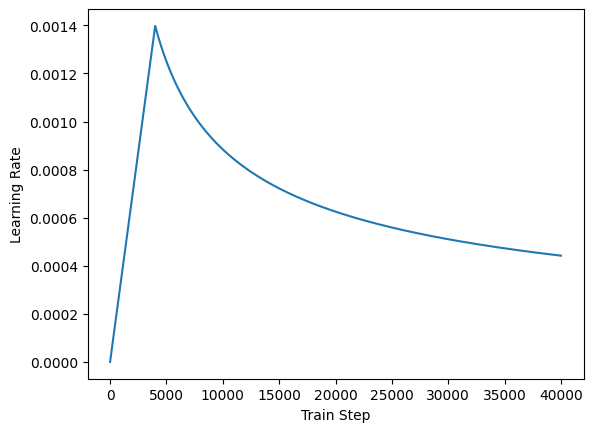

In [32]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [33]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [34]:
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')

In [35]:
transformer = Transformer(
    num_layers=num_layers,  # Số lớp trong mạng Transformer
    d_model=d_model,  # Kích thước vecror đầu ra
    num_heads=num_heads,  # Số lượng head trong mỗi encoder/decoder layer
    dff=dff,  # Kích thước của fully connected layer
    input_vocab_size=ENCODER_VOCAB,  # Số lượng từ trong từ điển đầu vào
    target_vocab_size=DECODER_VOCAB,  # Số lượng từ trong từ điển đầu ra
    pe_input=1000,  # Số lượng từ tối đa trong câu đầu vào
    pe_target=1000,  # Số lượng từ tối đa trong câu đầu ra
    rate=dropout_rate  # Tỷ lệ dropout
)

In [36]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)  # Encoder padding mask
    dec_padding_mask = create_padding_mask(inp)  # Decoder padding mask

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # Decoder look ahead mask
    dec_target_padding_mask = create_padding_mask(tar)  # Decoder target padding mask
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)  # Cộng hai mask lại với nhau

    return enc_padding_mask, combined_mask, dec_padding_mask  # Trả về các mask

Sử dụng checkpoint manager để lưu lại trạng thái của mô hình sau các epoch

In [37]:
checkpoint_path = "checkpoints"  # Đường dẫn lưu checkpoint
check_point_exists = False  # Biến kiểm tra checkpoint đã tồn tại hay chưa

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)  # Tạo checkpoint

ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=5 # Số lượng checkpoint lớn nhất được lưu lại
)  # Tạo checkpoint manager

if ckpt_manager.latest_checkpoint:  # Nếu trong thư mục có checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)  # Restore checkpoint mới nhất
    check_point_exists = True
    print("Đã load checkpoint")  # In ra đã restore checkpoint

Đã load checkpoint


In [38]:
@tf.function  # Tạo graph để tăng tốc độ
def train_step(inp, tar):  # Hàm train mô hình
    tar_inp = tar[:, :-1]  # Tạo input cho decoder bằng cách lấy tất cả các từ trong câu trừ từ cuối cùng
    tar_real = tar[:, 1:]  # Tạo ouput cho decoder bằng cách lấy tất cả các từ trong câu trừ từ đầu tiên

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)  # Tạo các mask

    with tf.GradientTape() as tape:  # Tạo gradient
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)  # Tính loss

    gradients = tape.gradient(loss, transformer.trainable_variables)  #   Tính gradient
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))  # Cập nhật trọng số mạng

    train_loss(loss)  # Cập nhật loss
    train_accuracy(accuracy_function(tar_real, predictions))  # Cập nhật accuracy

# Training the Model

In [39]:
# Ở đây tôi muốn nếu có checkpoint rồi thì chỉ cần sửa và không train thêm nữa
if check_point_exists:  # Nếu chưa có checkpoint
    EPOCHS = 0  # Số epoch /Nếu muốn train tiếp tục thì gán giá trị cho biến này

In [40]:
for epoch in range(EPOCHS):
    start = time.time()  # Lấy thời gian bắt đầu train

    train_loss.reset_states()  # Reset loss

    for (batch, (inp, tar)) in enumerate(dataset):  # Lặp qua các batch dữ liệu
        train_step(inp, tar)  # Train mô hình

        if batch % 100 == 0:  # In loss và accuracy sau mỗi 100 batch
            # In loss và accuracy
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:  # Lưu checkpoint sau mỗi 5 epoch
        ckpt_save_path = ckpt_manager.save()  # Lưu checkpoint
        # In ra đã lưu checkpoint
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

        #--------------------------------------------------------
        # Lưu checkpoints as zip very 5 epoch
    #         import zipfile
    #         import os

    #         # Đường dẫn đến thư mục cần nén lại
    #         folder_path = '/kaggle/working/checkpoints'

    #         # Đường dẫn đến tệp tin nén zip
    #         zip_path = 'zipfile_full_' + str(epoch + 1) + '.zip'

    #         # Tạo một tệp tin zip mới
    #         with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    #             # Đệ quy lấy tất cả các tệp tin và thư mục trong thư mục cần nén lại
    #             for root, dirs, files in os.walk(folder_path):
    #                 for file in files:
    #                     file_path = os.path.join(root, file)
    #                     # Thêm tệp tin vào tệp tin zip
    #                     zipf.write(file_path)
    #----------------------------------------------------------
      # In loss và accuracy sau mỗi epoch
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    # In ra thời gian train mỗi epoch
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

### Calculate

In [41]:
def calculate(input_english):
    input_english = english_tokenizer.texts_to_sequences([input_english])
    input_english = pad_sequences(input_english,
                                  maxlen=ENCODER_LEN,
                                  padding='post',
                                  truncating='post')

    encoder_input = tf.expand_dims(input_english[0], 0)

    decoder_input = [vietnamese_tokenizer.word_index['<S>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == vietnamese_tokenizer.word_index['</S>']:
            return tf.squeeze(output, axis=0)

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [42]:
def translation(input_english):
    vietnamese = calculate(input_english=input_english).numpy()
    vietnamese = np.expand_dims(vietnamese[1:], 0)
    return vietnamese_tokenizer.sequences_to_texts(vietnamese)[0]

# Test

In [43]:
en_content = test_data['en'][0]
vi_content = test_data['vi'][0]
predict = translation(en_content)
print("Full content is: ", en_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Sumary content is: ", vi_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

Full content is:  I thought you needed the sleep
@@@@@@@@@@@@@@@@@@@@@@
Sumary content is:  tôi nghĩ bạn cần ngủ
@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  tôi nghĩ bạn cần giấc ngủ


In [44]:
en_content = test_data['en'][1]
vi_content = test_data['vi'][1]
predict = translation(en_content)
print("Full content is: ", en_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Sumary content is: ", vi_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

Full content is:  You will survive.
@@@@@@@@@@@@@@@@@@@@@@
Sumary content is:  bạn sẽ sống sót.
@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  bạn sẽ sống sót


In [45]:
en_content = test_data['en'][2]
vi_content = test_data['vi'][2]
predict = translation(en_content)
print("Full content is: ", en_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Sumary content is: ", vi_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

Full content is:  He is a doctor and also a novelist
@@@@@@@@@@@@@@@@@@@@@@
Sumary content is:  ông là một bác sĩ và cũng là một tiểu thuyết gia
@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  ông là một bác sĩ và cũng là một tiểu thuyết tiểu thuyết


In [46]:
en_content = test_data['en'][3]
vi_content = test_data['vi'][3]
predict = translation(en_content)
print("Full content is: ", en_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Sumary content is: ", vi_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

Full content is:  What you were taught is wrong.
@@@@@@@@@@@@@@@@@@@@@@
Sumary content is:  những gì bạn đã được dạy là sai.
@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  những gì bạn đã được dạy là sai .


In [47]:
en_content = test_data['en'][4]
vi_content = test_data['vi'][4]
predict = translation(en_content)
print("Full content is: ", en_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Sumary content is: ", vi_content)
print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

Full content is:  I should've known Tom would be here, too
@@@@@@@@@@@@@@@@@@@@@@
Sumary content is:  tôi cũng nên biết tom cũng sẽ ở đây
@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  tôi cũng nên biết tom sẽ ở đây


In [48]:
en_content = "I don't like you to come to class late"
predict = translation(en_content)

print("@@@@@@@@@@@@@@@@@@@@@@")
print("Predict content is: ", predict)

@@@@@@@@@@@@@@@@@@@@@@
Predict content is:  tôi không thích bạn đến lớp trễ


## BLUE

In [49]:
from nltk.translate.bleu_score import corpus_bleu

references = []
hypotheses = []

for idx in range(30):
    en_content = test_data['en'][idx]
    vi_content = test_data['vi'][idx]

    # Generate the translation
    predict = translation(en_content)

    # Store the reference translation and the predicted translation
    references.append([vi_content.split()])
#     print(vi_content.split())
    hypotheses.append(predict.split())
#     print(predict.split())

# Calculate the BLEU score
bleu_score = corpus_bleu(references, hypotheses)

print("BLEU Score for the entire dataset: ", bleu_score)

BLEU Score for the entire dataset:  0.6820604101961745


# Tài liệu tham khảo:
- https://www.tensorflow.org/text/tutorials/transformer
- https://www.kaggle.com/code/ashishsingh226/text-summarization-with-transformers